# LSTM track-finding model with track parameter estimation

In this notebook we extend the method of the "simple" LSTM on 2D detector layers to include a regression on the estimation of the track parameters.

In [1]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers

# Local imports
from metrics import calc_hit_accuracy

# Magic
%matplotlib notebook

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 4007)


In [2]:
# Set random seed
np.random.seed(2017)

## Utilities

In [ ]:
def draw_layer(ax, data, title=None, **kwargs):
    """Draw one detector layer as an image"""
    ax.imshow(data.T, interpolation='none', aspect='auto',
              origin='lower', **kwargs)
    if title is not None:
        ax.set_title(title)

def draw_layers(event, ncols=5, truthx=None, truthy=None, figsize=(12,5)):
    """Draw each detector layer as a grid of images"""
    num_det_layers = event.shape[0]
    nrows = math.ceil(float(num_det_layers)/ncols)
    plt.figure(figsize=figsize)
    for ilay in range(num_det_layers):
        ax = plt.subplot(nrows, ncols, ilay+1)
        title = 'layer %i' % ilay
        draw_layer(ax, event[ilay], title=title)
        ax.autoscale(False)
        if truthx is not None and truthy is not None:
            ax.plot(truthx[ilay]-0.5, truthy[ilay]-0.5, 'w+')
    plt.tight_layout()

def draw_train_history(history, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['outputHits_loss'], label='Training hits')
    plt.plot(history.epoch, history.history['val_outputHits_loss'], label='Validation hits')
    plt.plot(history.epoch, history.history['outputParams_loss'], label='Training params')
    plt.plot(history.epoch, history.history['val_outputParams_loss'], label='Validation params')
    plt.plot(history.epoch, history.history['loss'], label='Training total')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation total')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['outputHits_acc'], label='Training set')
    plt.plot(history.epoch, history.history['val_outputHits_acc'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 0.5))
    plt.title('Training accuracy')
    plt.legend()
    plt.tight_layout()

def draw_projections(event, truthx=None, truthy=None, figsize=(12,5)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    kwargs = dict(interpolation='none',
                  aspect='auto',
                  origin='lower')
    plt.imshow(event.sum(axis=1).T, **kwargs)
    plt.xlabel('detector layer')
    plt.ylabel('pixel')
    plt.autoscale(False)
    if truthy is not None:
        plt.plot(np.arange(event.shape[0]-0.5), truthy-0.5, 'w-')
    plt.subplot(122)
    plt.imshow(event.sum(axis=2).T, **kwargs)
    plt.xlabel('detector layer')
    plt.ylabel('pixel')
    plt.tight_layout()
    plt.autoscale(False)
    if truthx is not None:
        plt.plot(np.arange(event.shape[0]-0.5), truthx-0.5, 'w-')

In [49]:
def gen_noise(shape, prob=0.1, seed_layers=0):
    noise = (np.random.random_sample(shape) < prob).astype(np.int8)
    noise[:,:seed_layers,:,:] = 0
    return noise

def sample_track_params(n, num_det_layers, det_layer_size):
    # Sample the entry and exit points for tracks
    entry_points = np.random.uniform(0, det_layer_size, size=(n, 2))
    exit_points = np.random.uniform(0, det_layer_size, size=(n, 2))    
    # Calculate slope parameters
    slopes = (exit_points - entry_points) / float(num_det_layers - 1)
    return np.concatenate([slopes, entry_points], axis=1)

def track_hit_coords(params, det_layer_idx, as_type=np.int):
    xslope, yslope, xentry, yentry = params
    xhits = xslope*det_layer_idx + xentry
    yhits = yslope*det_layer_idx + yentry
    return xhits.astype(as_type), yhits.astype(as_type)
    
def gen_straight_tracks(n, num_det_layers, det_layer_size):
    # Initialize the data
    data = np.zeros((n, num_det_layers, det_layer_size, det_layer_size),
                    dtype=np.float32)
    # Sample track parameters
    params = sample_track_params(n, num_det_layers, det_layer_size)
    # Calculate hit positions and fill hit data
    idx = np.arange(num_det_layers)
    for ievt in range(n):
        xhits, yhits = track_hit_coords(params[ievt], idx)
        data[ievt,idx,xhits,yhits] = 1   
    return data, params

def gen_bkg_tracks(num_event, num_det_layers, det_layer_size,
                   avg_bkg_tracks=3, seed_layers=0):
    num_bkg_tracks = np.random.poisson(avg_bkg_tracks, num_event)
    bkg_tracks = np.zeros((num_event, num_det_layers, det_layer_size, det_layer_size),
                          dtype=np.float32)
    for ievt in range(num_event):
        ntrk = num_bkg_tracks[ievt]
        bkg_tracks[ievt] = sum(gen_straight_tracks_2d(ntrk, num_det_layers, det_layer_size)[0])
    bkg_tracks[:,:seed_layers,:,:] = 0
    return bkg_tracks

In [5]:
def flatten_layers(data):
    """Flattens each 2D detector layer into a 1D array"""
    return data.reshape((data.shape[0], data.shape[1], -1))

def flat_to_2d(data, det_width):
    """Expands the flattened layers to original (width x width)"""
    return data.reshape((data.shape[0], data.shape[1], det_width, det_width))

## Configuration

In [6]:
num_event = 102400
num_det_layers = 10
det_layer_size = 32
num_seed_layers = 3
avg_bkg_tracks = 3
noise_prob = 0.
shape = (num_event, num_det_layers, det_layer_size, det_layer_size)
det_shape = shape[1:]

## Data generation

In [7]:
# Signal tracks
sig_tracks, sig_params = (
    gen_straight_tracks(num_event, num_det_layers, det_layer_size))
# Background tracks
bkg_tracks = gen_bkg_tracks(num_event, num_det_layers, det_layer_size,
                            avg_bkg_tracks=avg_bkg_tracks,
                            seed_layers=num_seed_layers)
# Noise
noise = gen_noise(shape, prob=noise_prob, seed_layers=num_seed_layers)

# Full events
events = sig_tracks + bkg_tracks + noise
events[events > 1] = 1

# Print data sizes
print('Sizes of arrays')
print('  events:     %g MB' % (events.dtype.itemsize * events.size / 1e6))
print('  sig_tracks: %g MB' % (sig_tracks.dtype.itemsize * sig_tracks.size / 1e6))
print('  bkg_tracks: %g MB' % (bkg_tracks.dtype.itemsize * bkg_tracks.size / 1e6))
print('  noise:      %g MB' % (noise.dtype.itemsize * noise.size / 1e6))

# Cleanup
del bkg_tracks
del noise

Sizes of arrays
  events:     4194.3 MB
  sig_tracks: 4194.3 MB
  bkg_tracks: 4194.3 MB
  noise:      1048.58 MB


<IPython.core.display.Javascript object>


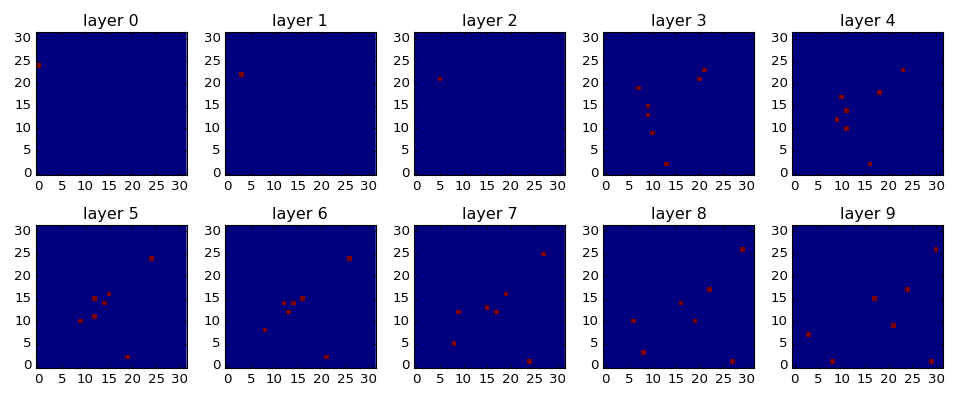

In [8]:
# Visualize one event
draw_layers(events[0])

## Define the model

In [13]:
def build_model(det_shape, num_hidden=100,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    det_depth, det_width, _ = det_shape
    # Model inputs
    inputs = layers.Input(shape=(det_depth-1, det_width*det_width))
    # LSTM layer
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    # Output fully-connected layer
    outputs = layers.TimeDistributed(layers.Dense(det_width**2, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

def build_deep_model(det_shape, num_hidden=100,
                     loss='categorical_crossentropy',
                     optimizer='Nadam', metrics=['accuracy']):
    det_depth, det_width, _ = det_shape
    # Model inputs
    inputs = layers.Input(shape=(det_depth-1, det_width*det_width))
    # Input fully-connected layer
    hidden = layers.TimeDistributed(layers.Dense(num_hidden, activation='relu'))(inputs)
    # LSTM layer
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(hidden)
    # Output fully-connected layers
    hidden = layers.TimeDistributed(layers.Dense(num_hidden, activation='relu'))(hidden)
    outputs = layers.TimeDistributed(layers.Dense(det_width**2, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

def build_multi_model(det_shape, num_hidden=100,
                      losses=['categorical_crossentropy', 'mse'],
                      loss_weights=[0.5, 0.5],
                      optimizer='Nadam', metrics=['accuracy']):
    det_depth, det_width, _ = det_shape
    # Model inputs
    inputs = layers.Input(shape=(det_depth-1, det_width*det_width))
    
    # LSTM layer
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    
    # Fully-connected layer for detector output
    det_outputs = layers.TimeDistributed(
        layers.Dense(det_width**2, activation='softmax'), name='outputHits')(hidden)
    
    # Fully-connected layer for track parameter output
    track_hidden = layers.Flatten()(hidden)
    track_outputs = layers.Dense(4, name='outputParams')(track_hidden)
    
    # Compile the model
    model = models.Model(input=inputs, output=[det_outputs, track_outputs])
    model.compile(loss=losses, loss_weights=loss_weights,
                  optimizer=optimizer, metrics=metrics)
    return model

## Training

In [14]:
# Configure the training
num_hidden = 512
batch_size = 512
num_epoch = 20
valid_frac = 0.2

train_input = flatten_layers(events[:,:-1,:,:])
train_target = flatten_layers(sig_tracks[:,1:,:,:])

In [15]:
# Build the model
model = build_multi_model(det_shape, num_hidden=num_hidden)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 9, 1024)       0                                            
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 9, 512)        3147776     input_2[0][0]                    
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 4608)          0           lstm_2[0][0]                     
____________________________________________________________________________________________________
outputHits (TimeDistributed)     (None, 9, 1024)       525312      lstm_2[0][0]                     
___________________________________________________________________________________________

In [16]:
# Train the model
history = model.fit(train_input, [train_target, sig_params],
                    batch_size=batch_size, nb_epoch=num_epoch,
                    validation_split=valid_frac)

# Get all of the training data predictions
train_preds = model.predict(train_input, batch_size=batch_size)

Train on 81920 samples, validate on 20480 samples
Epoch 1/20
81920/81920 [==============================] - 17s - loss: 9.8420 - outputHits_loss: 6.8332 - outputParams_loss: 12.8508 - outputHits_acc: 0.0029 - outputParams_acc: 0.8595 - val_loss: 4.2368 - val_outputHits_loss: 6.7349 - val_outputParams_loss: 1.7388 - val_outputHits_acc: 0.0038 - val_outputParams_acc: 0.9619
Epoch 2/20
81920/81920 [==============================] - 17s - loss: 4.0743 - outputHits_loss: 6.6638 - outputParams_loss: 1.4848 - outputHits_acc: 0.0038 - outputParams_acc: 0.9669 - val_loss: 3.8287 - val_outputHits_loss: 6.6088 - val_outputParams_loss: 1.0486 - val_outputHits_acc: 0.0039 - val_outputParams_acc: 0.9711
Epoch 3/20
81920/81920 [==============================] - 17s - loss: 3.8380 - outputHits_loss: 6.5417 - outputParams_loss: 1.1343 - outputHits_acc: 0.0043 - outputParams_acc: 0.9696 - val_loss: 3.6703 - val_outputHits_loss: 6.4766 - val_outputParams_loss: 0.8640 - val_outputHits_acc: 0.0046 - val_ou

In [3]:
    draw_train_history(history)

NameError: name 'history' is not defined

In [50]:
# Select an event to visualize
disp_idx = 6

# Get the hit coordinates for drawing
idx = np.arange(num_det_layers)
xtruth, ytruth = track_hit_coords(sig_params[disp_idx], idx, as_type=np.float32)

<IPython.core.display.Javascript object>


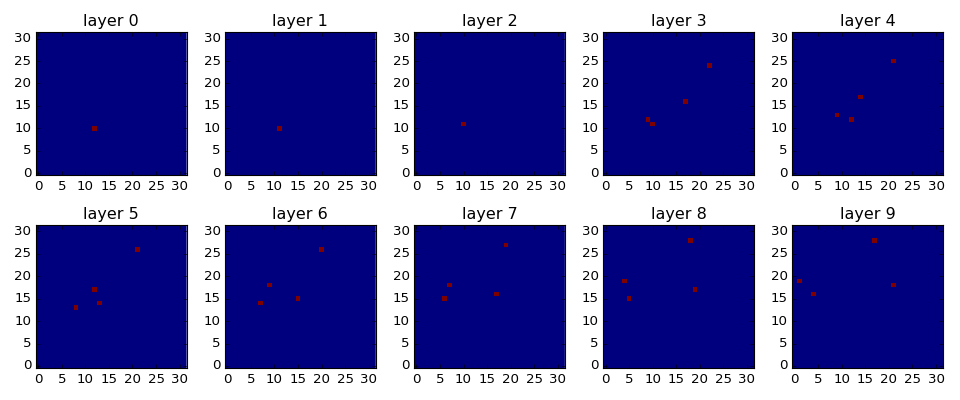

<IPython.core.display.Javascript object>


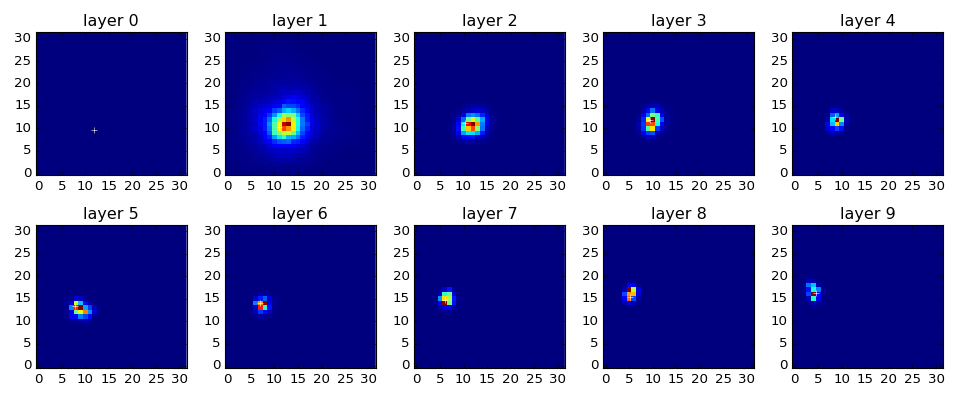

In [51]:
# Visualize one event
disp_idx = 6
draw_layers(events[disp_idx], figsize=(12,5))

pred = np.zeros(det_shape)
pred[1:] = train_preds[0][disp_idx].reshape((num_det_layers-1, det_layer_size, det_layer_size))
draw_layers(pred, figsize=(12,5), truthx=xtruth, truthy=ytruth)

In [40]:
calc_hit_accuracy(train_preds[0], train_target, num_seed_layers=num_seed_layers)

0.2936702473958333

In [41]:
# Now let's try to compute additional metrics, such as hit classification accuracy,
# whereby we only look at pixels that have a hit. To do this, we first multiply
# the prediction scores with the binary data.
scores = train_preds[0] * flatten_layers(events[:,1:,:,:])
calc_hit_accuracy(scores, train_target)

0.9739637586805555

<IPython.core.display.Javascript object>


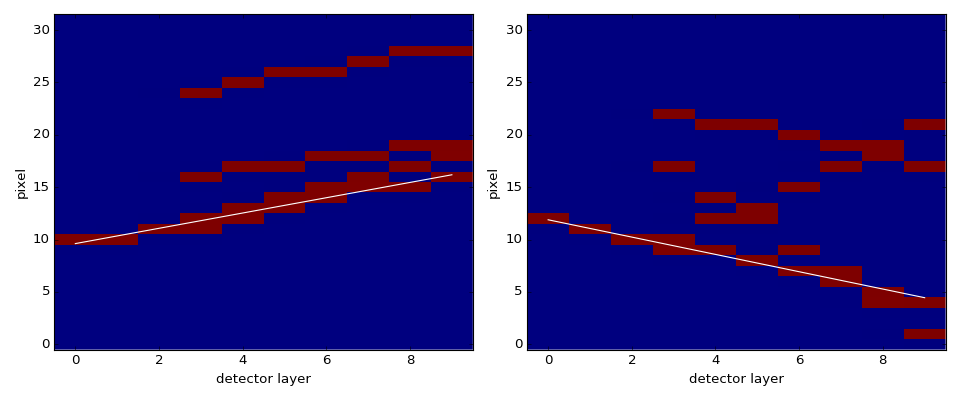

<IPython.core.display.Javascript object>


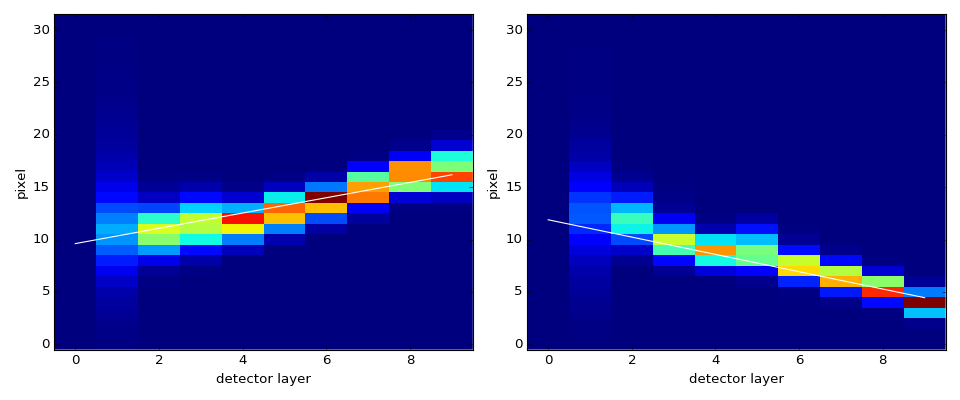

In [52]:
# Draw the 2D projections
draw_projections(events[disp_idx], figsize=(12,5), truthx=xtruth, truthy=ytruth)
draw_projections(pred, figsize=(12,5), truthx=xtruth, truthy=ytruth)

In [55]:
# x-slope, y-slope, x-entry, y-entry
print(train_preds[1][disp_idx])
print(sig_params[disp_idx])

[ -0.64124906   0.79074138  12.83319187  10.66732883]
[ -0.82660649   0.72989965  12.39386028  10.11985986]
